# Image Classification of Plants

<p>Goal is to classify if the plant is healthy or diseased.</p>
<p>The dataset used is available at: <a href="https://github.com/pratikkayal/PlantDoc-Dataset">Pratik Kayal's GitHub</a>
<p>TensorFlow guide used: <a href="https://www.tensorflow.org/lite/models/modify/model_maker/image_classification">TensorFlow Lite Guide</a>

## Necessary Package Install
Run the code below this textbox, as Google Colab doesn't come with Tensorflor Lite's Model Maker by default!

In [ ]:
!pip install -q tflite-model-maker

     |████████████████████████████████| 577 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 31.1 MB/s 
     |████████████████████████████████| 128 kB 35.7 MB/s 
     |████████████████████████████████| 3.4 MB 32.5 MB/s 
     |████████████████████████████████| 1.3 MB 47.5 MB/s 
     |████████████████████████████████| 238 kB 48.0 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 840 kB 48.8 MB/s 
     |████████████████████████████████| 87 kB 5.3 MB/s 
     |████████████████████████████████| 10.9 MB 46.9 MB/s 
     |████████████████████████████████| 60.2 MB 1.5 MB/s 
     |████████████████████████████████| 25.3 MB 2.0 MB/s 
     |████████████████████████████████| 352 kB 41.6 MB/s 
     |████████████████████████████████| 99 kB 6.8 MB/s 
     |████████████████████████████████| 40 kB 4.9 MB/s 
     |████████████████████████████████| 213 kB 14.6 MB/s 
     |████████████████████████████████| 1.1 MB 37.0 MB/s 


## Necessary Packages
These packages are required.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

## Parameters
Changing the parameters here will affect the model

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
base_learning_rate = 0.0001
MODEL_SPEC = 'mobilenet_v2'
EPOCHS = 50

## PlantDoc Dataset

Bibtex:
</br>
<code>
@inproceedings{10.1145/3371158.3371196,</br>
author = {Singh, Davinder and Jain, Naman and Jain, Pranjali and Kayal, Pratik and Kumawat, Sudhakar and Batra, Nipun},</br>
title = {PlantDoc: A Dataset for Visual Plant Disease Detection},</br>
year = {2020},</br>
isbn = {9781450377386},</br>
publisher = {Association for Computing Machinery},</br>
address = {New York, NY, USA},</br>
url = {https://doi.org/10.1145/3371158.3371196},</br>
doi = {10.1145/3371158.3371196},</br>
booktitle = {Proceedings of the 7th ACM IKDD CoDS and 25th COMAD},</br>
pages = {249–253},</br>
numpages = {5},</br>
keywords = {Deep Learning, Object Detection, Image Classification},</br>
location = {Hyderabad, India},</br>
series = {CoDS COMAD 2020}</br>
}
</code>

In [ ]:
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git

Cloning into 'PlantDoc-Dataset'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2670 (delta 23), reused 41 (delta 22), pack-reused 2628
Receiving objects: 100% (2670/2670), 932.92 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Checking out files: 100% (2581/2581), done.


## Making directories
Tensorflow uses folder names as the labels. Hence, here I've split the dataset into train & test, and it is further subdivided into healthy and unhealthy

In [ ]:
!mkdir /content/Dataset
!mkdir /content/Dataset/test
!mkdir /content/Dataset/test/healthy
!mkdir /content/Dataset/test/unhealthy
!mkdir /content/Dataset/train
!mkdir /content/Dataset/train/healthy
!mkdir /content/Dataset/train/unhealthy

## Moving of files into appropriate folders
<p>Here, the files are looped through, renamed, and moved to the destination folder.</p>

<ul>
<li>PATH is where the dataset is downloaded into.</li>
<li>FOLDERS_INTERESTED is an array containing the subdirectories in the dataset that you're interest in.</li>
<li>CONDITIONS is an array of unhealthy conditions that are tagged to the original image files.</li>
</ul>


In [ ]:
CONDITIONS = ["Scab", "rust", "spot", "Gray", "blight", "mildew", "mosaic", "yellow", "mold", "mites", "rot"]
PATH = "/content/PlantDoc-Dataset"
FOLDERS_INTERESTED = ["/test/", "/train/"]
print(PATH)
for FOLDER_INTERESTED in FOLDERS_INTERESTED:
  FOLDER_PATH = PATH + FOLDER_INTERESTED
  print(FOLDER_PATH)
  folders = os.listdir(FOLDER_PATH)
  for folder in folders:
    i = 0
    files = os.listdir(FOLDER_PATH + folder)
    for file in files:
      original_path = FOLDER_PATH + folder + "/" + file
      flag = False
      for condition in CONDITIONS:
        if condition in folder:
          flag = True
          break
      if flag:
        os.rename(original_path, "/content/Dataset" + FOLDER_INTERESTED + "unhealthy/" + folder + "_" + str(i) + ".jpg")
      else:
        os.rename(original_path, "/content/Dataset" + FOLDER_INTERESTED + "healthy/" + folder + "_" + str(i) + ".jpg")
      i += 1

/content/PlantDoc-Dataset
/content/PlantDoc-Dataset/test/
/content/PlantDoc-Dataset/train/


## Tensorflow Lite Implementation
<p>
Here, we start the implementation.
</p>
<p>
The data is split into train, test, and validation datasets. The train dataset is used to initially train the image classifier. Whereas, the validation dataset is used in tuning the parameters of the classifier. The test dataset is a set of images that the model will not see in it's training phase, it'll be used to evaluate the model's performance.
</p>

In [ ]:
train_data = DataLoader.from_folder('/content/Dataset/train')
test_data = DataLoader.from_folder('/content/Dataset/test')
validation_data, test_data = test_data.split(0.5)

Below, the model is trained for a specified number of epochs. This means that the model is trained over the train dataset for the number of epochs specified. The model_spec parameter determines what type of pretrained model will be used.

In [ ]:
model = image_classifier.create(
    train_data, 
    model_spec=model_spec.get(MODEL_SPEC), 
    validation_data=validation_data,
    batch_size = BATCH_SIZE,
    learning_rate = base_learning_rate,
    shuffle = True,
    use_augmentation = True,
    epochs = EPOCHS,
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             2257984   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/50
73/73 [==============================] - 106s 1s/step - loss: 0.8020 - accuracy: 0.5878 - val_loss: 0.7644 - val_accuracy: 0.5763
Epoch 2/50
73/73 [==============================] - 100s 1s/step - loss: 0.6332 - accuracy: 0.

Here, the model will be evaluated on the test dataset.

In [ ]:
loss, accuracy = model.evaluate(test_data)

4/4 [==============================] - 7s 1s/step - loss: 0.3646 - accuracy: 0.9237


### Prediction
Here, the model will run prediction on the top_k number of images in the test dataset.

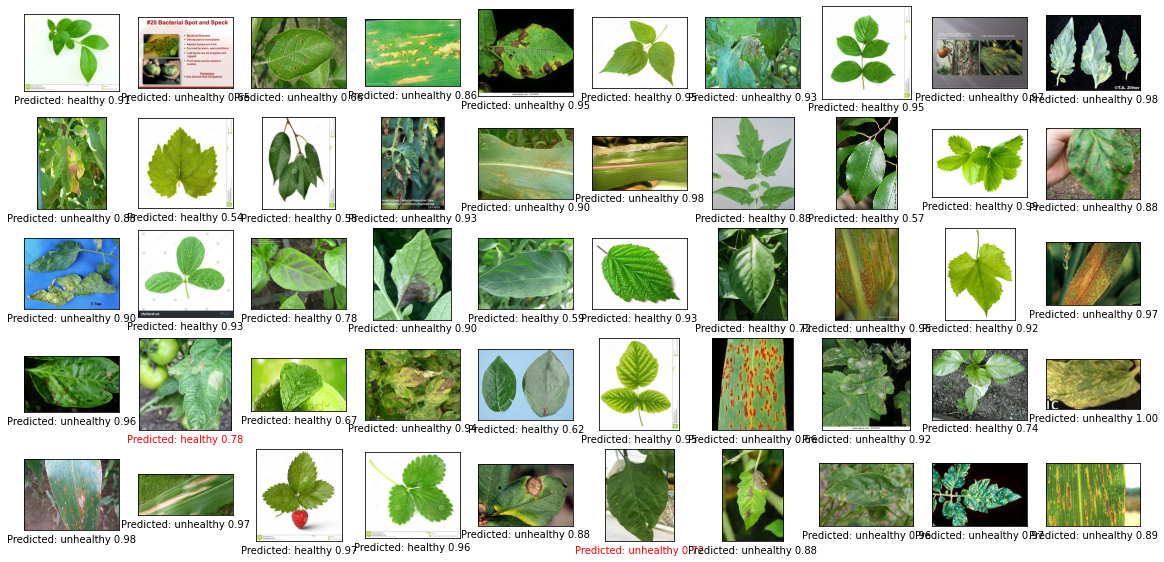

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(50)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s %.2f' % (predict_label, predicts[i][0][1]))
plt.show()

## Making directories to save the model

In [ ]:
!mkdir /content/tflite_model_PlantDoc
!mkdir /content/tflite_model_PlantDoc/saved_model

The model is exported to the directories that we've made above.

In [ ]:
model.export(export_dir='/content/tflite_model_PlantDoc', export_format=ExportFormat.SAVED_MODEL)
model.export(export_dir='/content/tflite_model_PlantDoc', export_format=ExportFormat.LABEL)

## TensorFlow to TensorFlow Lite Conversion
Below, the previously saved model will be converted into TensorFlow Lite. Additional arguments are added for optimization for microcontrollers.

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/tflite_model_PlantDoc/saved_model")
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

The bytecode is then written to model.tflite

In [ ]:
# Save the model.
with open('/content/model.tflite', 'wb') as f:
  f.write(tflite_model)

A Linux command to convert the bytecode in model.tflite to C.

In [ ]:
!xxd -i /content/model.tflite > /content/model.h

## In the MCUxpresso Project
<p>
  Copy the contents of model.h into model_data.h under source/model in the MCUxpresso project.
</p>
<p>
  At the top of model_data.h, you'll need to add this code:
</p>
<code>
  #ifndef __XCC__
  </br>
  #include < cmsis_compiler.h >
  </br>
  #else
  </br>
  #define __ALIGNED(x)__attribute__((aligned(x)))
  </br>
  #endif
  </br>
  #define MODEL_NAME "efficientnet_lite0_leaf"
  </br>
  #define MODEL_INPUT_MEAN 0.0f
  </br>
  #define MODEL_INPUT_STD 255.0f
  </br>
  unsigned char model_tflite[] = {
    0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
    ...
    0x0c, 0x00, 0x00, 0x00, 0x12, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x12
  };
  </br>
  unsigned int model_tflite_len = 8877684;
</code>
</br>
<p>
  In model.cpp do these:
</p>
<ul>
  <li>
    After line 23:
    <code>
    #include "tensorflow/lite/micro/all_ops_resolver.h"
    </code>
  </li>
  <li>
    On line 40, update the expression such that it fits the arena size in our case 6050000 is good enough.
  </li>
  <li>
    On line 53, change the model_name to model_tflite.
  </li>
  <li>
  Comment out line 71, and add this:
  <code>
    tflite::AllOpsResolver micro_op_resolver;
  </code>
  </li>
</ul>
<p>In labels.h change it to the labels that the model will output, the labels should be in alphabetical order.
</p>
<code>
  #ifndef _LABELS_H_
  </br>
  #define _LABELS_H_
  </br>
  static const char* labels[] = {
    "healthy",
	  "unhealthy"
  };
  </br>
  #endif // _LABELS_H_
</code>